In [2]:
# To use it in colab use this code to import the data. 
# Its necessarc to complet the following steps in advance: 
# 1. Create a folder in your drive with the Name DMC. 
# 2. Go to the shard folder 02 Data and do a right click -> Add shortcut to Drive / Drve Verbindung hinzufügen -> dann auf den eben erstellen order DMC navigieren
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from math import sqrt
import time
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split as train_test_split_sk

#1. Extract Netflix Prize Data from Text to CSV

In [ ]:
def convert(): 
    start = datetime.now()
    if not os.path.isfile('webmining/data_1.csv'):
        #read all txt file and store them in one big file
        data = open('webmining/data_1.csv', mode='w')
    
        row = list()
        files = [
            'webmining/combined_data_1.txt'
            #'webmining/combined_data_2.txt'
            #,
            #'webmining/combined_data_3.txt'
            #, 
            #'webmining/combined_data_4.txt'
        ]
        for file in files:
            print('reading ratings from {}...'.format(file))
            with open(file) as f:
                for line in f:
                    del row[:]
                    line = line.strip()
                    if line.endswith(':'):
                        #all are rating
                        movid_id = line.replace(':', '')
                    else:
                        row = [x for x in line.split(',')]
                        row.insert(0, movid_id)
                        data.write(','.join(row))
                        data.write('\n')
            print('Done.\n')
        data.close()
    print('time taken:', datetime.now() - start);

In [ ]:
convert()

#2. Convert Integrated Fused CSV to Readable DF

In [ ]:
df_links = pd.read_csv('webmining/fused.csv', delimiter=';')

In [ ]:
df_links = df_links.drop(['title/_provenance'], axis=1)
df_links.rename(columns={
    'release_year/_provenance':'imdb_metadata_id', 
    'release_year/__text': 'release_year',
    'title/__text': 'title'
}, inplace=True)

In [ ]:
df_links['id'] = df_links['id'].map(lambda x: x[0:x.find('+')])

# 9707 not found titles

In [ ]:
df_links['imdb_metadata_id'] = df_links['imdb_metadata_id'].map(lambda x: x.replace('metadata_', ''))


              id	release_year	title	imdb_metadata_id
              0	1	2003.0	Dinosaur Planet	NaN
              1	2	2004.0	Isle of Man TT 2004 Review	NaN
              2	3	1997.0	Character	17139
              3	4	1994.0	Paula Abdul's Get Up & Dance	NaN
              4	5	2004.0	The Rise and Fall of ECW	33209

In [ ]:
df_links.to_csv('webmining/final_movies_metadata_linked.csv', sep=';', encoding='utf-8')

#3. Preprocessing, EDA on Truncated Data

In [ ]:
#Read Extended Data

df_titles_extended = pd.read_csv("/content/drive/My Drive/Web Mining Project/NEW_DATA/final_movies_metadata_linked.csv", delimiter=';')
df_titles_extended.drop(['Unnamed: 0'], axis=1, inplace=True)
df_titles_extended.head()

,netflix_id,title,release_year,metadata_id,imdb_id,original_language,overview,tagline,metadata_genres,netflix_genres
0,402,Pan Tadeusz,1999,4966,tt0170351,pl,A grand and patriotic tale of Poland's struggl...,NaN,"[{'id': 10752, 'name': 'War'}, {'id': 18, 'nam...",Drama|History|Romance|War
1,17617,Ginger,1971,89072,tt0067133,en,The police suspect that a drug and forced-pros...,"Every man wanted her, no man could tame her! T...","[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",Action|Crime|Drama
2,11805,The Big Bounce,2004,12634,tt0315824,en,A small-time con artist and a Hawaiian real es...,It's all in who you trust,"[{'id': 35, 'name': 'Comedy'}, {'id': 80, 'nam...",Comedy|Crime
3,459,Basquiat,1996,549,tt0115632,en,Director Julian Schnabel illustrates the portr...,"In 1981, A Nineteen-Year-Old Unknown Graffiti ...","[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",Biography|Drama
4,4607,Melody Time,1948,13757,tt0040580,en,Melody Time is an animated feature produced by...,NaN,"[{'id': 10402, 'name': 'Music'}, {'id': 10751,...",Animation|Comedy|Family|Musical


In [ ]:
df_titles_extended.shape

(8068, 10)

In [ ]:
##Load Movie Title data
df_titles_original = pd.read_csv('/content/drive/My Drive/Web Mining Project/Org. Dataset for Netflix/movie_titles.csv', encoding = "ISO-8859-1", delimiter=',', names=['id', 'release_year', 'title'])
print(df_titles_original.shape)

#Create dictionary of movie_id to title so that we can use it later to determine title when recommending items
dict_id_title = df_titles_original.set_index("id")["title"].to_dict()
print(dict_id_title)

In [ ]:
df_ratings = pd.read_csv("/content/drive/My Drive/Web Mining Project/NEW_DATA/Truncated/data_1.csv", delimiter=',', names=['movie_id','user_id','rating','rating_date'])
df_ratings.head()

,movie_id,user_id,rating,rating_date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


In [ ]:
#Create Movies dataframe to explore movie's avg rating and number of ratings received by user
df_titles_info = pd.DataFrame(df_ratings.groupby('movie_id')['rating'].mean())
df_titles_info['count'] = df_ratings.groupby('movie_id')['rating'].count()
df_titles_info["title"] = pd.Series(dict_id_title)
df_titles_info['movie_id'] = df_titles_info.index

In [ ]:
df_titles_info.head()

,rating,count,title,movie_id
3,3.641153,2012,Character,3
5,3.919298,1140,The Rise and Fall of ECW,5
8,3.189805,14910,What the #$*! Do We Know!?,8
12,3.417582,546,My Favorite Brunette,12
17,2.903208,7108,7 Seconds,17


In [ ]:
df_titles_info.shape

(2042, 4)

In [ ]:
df_titles_info.index.name = None

In [ ]:
df_titles_info = pd.merge(df_titles_info, df_titles_extended[['netflix_id','overview']], left_on='movie_id', right_on='netflix_id', how='left')

In [ ]:
df_titles_info.head()

,rating,count,title,movie_id,netflix_id,overview
0,3.641153,2012,Character,3,3,J.W. Katadreuffe is the son of Joba Katadreuff...
1,3.919298,1140,The Rise and Fall of ECW,5,5,ECW: Extreme Championship Wrestling redefined ...
2,3.189805,14910,What the #$*! Do We Know!?,8,8,Amanda (Marlee Maitlin) is a divorced woman wh...
3,3.417582,546,My Favorite Brunette,12,12,"Baby photographer Ronnie Jackson, on death row..."
4,2.903208,7108,7 Seconds,17,17,When an experienced thief accidentally makes o...


In [ ]:
df_titles_info.shape

(2043, 6)

In [ ]:

list_titles = list(df_titles_info['movie_id'])

print(len(list_titles))

2043


In [ ]:
df_ratings.shape

(24053764, 4)

In [ ]:
df_ratings = df_ratings[df_ratings['movie_id'].isin(list_titles)]

In [ ]:
df_ratings.shape

(20377417, 4)

In [ ]:
##Create Users dataframe to explore user's avg rating and number of ratings given by user
df_users = pd.DataFrame(df_ratings.groupby('user_id')['rating'].mean())
df_users['count'] = df_ratings.groupby('user_id')['rating'].count()
df_users.head()

,rating,count
user_id,,
6,3.393701,127
7,4.045977,174
8,4.000000,21
10,3.304348,46
25,3.333333,3


In [ ]:
print(df_users.shape)
print(df_titles_info.shape)

(467350, 2)
(2043, 6)


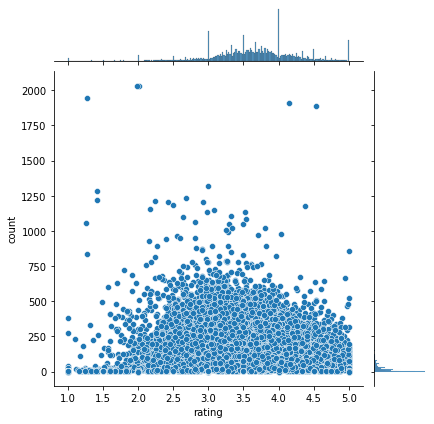

In [ ]:
sns.jointplot(x='rating', y='count', data=df_users)

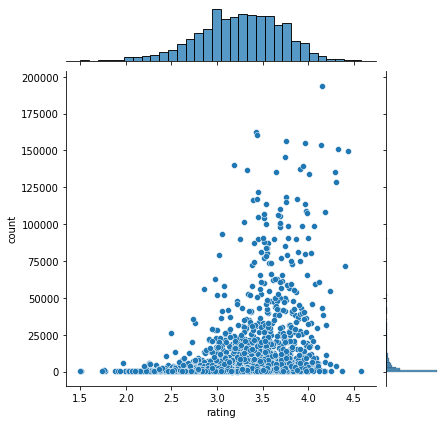

In [ ]:
sns.jointplot(x='rating', y='count', data=df_titles_info)

(0.0, 5.0)

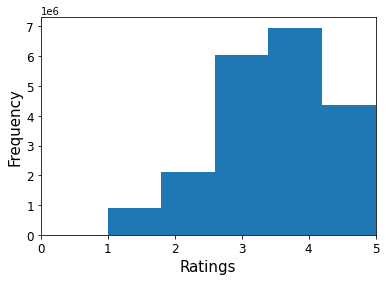

In [ ]:
df_ratings['rating'].hist(bins=5, grid=False, xlabelsize=12, ylabelsize=12)
plt.xlabel("Ratings", fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.xlim([0,5.0])

Text(0, 0.5, 'Frequency of users')

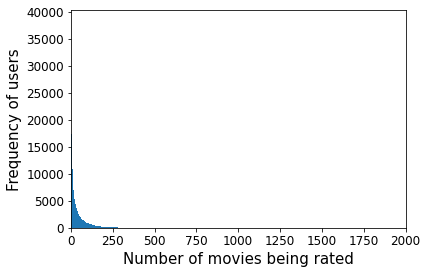

In [ ]:
# Distribution of the number of users and the number of movies rated per user
df_users['count'].hist(bins=2000, grid=False, xlabelsize=12, ylabelsize=12)
plt.xlim([0,2000])
plt.xlabel("Number of movies being rated", fontsize=15)
plt.ylabel("Frequency of users",fontsize=15)

In [ ]:
##Removing users who rated less than 50 movies and removing movies which are not rated y atleast 100 users
df_users_f = df_users.drop(df_users[df_users['count'] < 100].index)

df_titles_f = df_titles_info.drop(df_titles_info[df_titles_info['count'] < 100].index)

In [ ]:
print(df_titles_info.shape)
print(df_titles_f.shape)
print(df_users.shape)
print(df_users_f.shape)

print('Preserved rate of the movies : {0:.2f} %'.format((df_titles_f.shape[0]/df_titles_info.shape[0]) * 100))
print('Preserved rate of the users : {0:.2f} %'.format((df_users_f.shape[0]/df_users.shape[0]) * 100))

(2043, 6)
(1998, 6)
(467350, 2)
(57357, 2)
Preserved rate of the movies : 97.80 %
Preserved rate of the users : 12.27 %


In [ ]:
list_users_f = list(df_users_f.index.values)
list_titles_f = list(df_titles_f.index.values)

print(len(list_users_f))
print(len(list_titles_f))

57357
1998


Text(0, 0.5, 'Frequency of users')

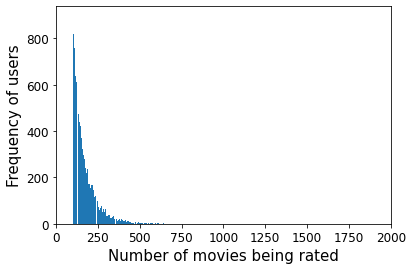

In [ ]:
# Distribution of the number of users and the number of movies rated per user
df_users_f['count'].hist(bins=2000, grid=False, xlabelsize=12, ylabelsize=12)
plt.xlim([0,2000])
plt.xlabel("Number of movies being rated", fontsize=15)
plt.ylabel("Frequency of users",fontsize=15)

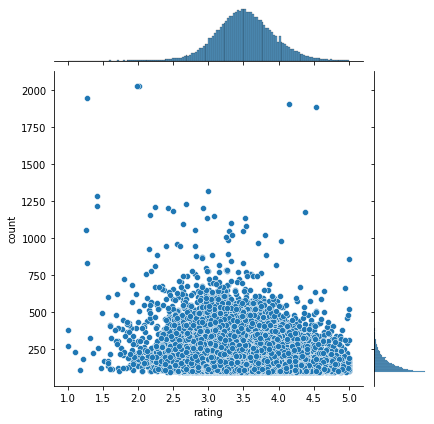

In [ ]:
sns.jointplot(x='rating', y='count', data=df_users_f)

In [ ]:
df_ratings = df_ratings[df_ratings['user_id'].isin(list_users_f)]
df_ratings = df_ratings[df_ratings['movie_id'].isin(list_titles_f)]
print(df_ratings.shape)
print(df_ratings.info(memory_usage='deep'))

(4265493, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4265493 entries, 693 to 10495914
Data columns (total 4 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   movie_id     int64 
 1   user_id      int64 
 2   rating       int64 
 3   rating_date  object
dtypes: int64(3), object(1)
memory usage: 402.7 MB
None


In [ ]:
df_ratings.to_csv('/content/drive/My Drive/Web Mining Project/NEW_DATA/Truncated/truncated_ratings.csv', sep=';', encoding='utf-8')

In [ ]:
#Create dictionary of movie_id to title so that we can use it later to determine title when recommending items
Mapping_file = dict(zip(df_titles.title.tolist(), df_titles.id.tolist()))

# 4. Find Best Model by Training on Truncated Data

SVD, NMF, Co-Clustering



In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8MB 4.7MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617647 sha256=fbfdbc99a5a15de6b030a29ca430b3c7a705d079fbf2007f26c3e145e6a4abf8
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


## Split the Dataset into train and test

In [ ]:
##Load Movie Title data
df_titles = pd.read_csv('/content/drive/My Drive/Web Mining Project/Org. Dataset for Netflix/movie_titles.csv', encoding = "ISO-8859-1", delimiter=',', names=['id', 'release_year', 'title'])
print(df_titles.shape)

(17770, 3)


In [ ]:
df_ratings = pd.read_csv("/content/drive/My Drive/Web Mining Project/NEW_DATA/Truncated/truncated_ratings.csv", delimiter=';')

In [ ]:
df_ratings.shape

(4265493, 5)

In [ ]:
# Train SVD on 75% of known rates
rawTrain, rawTest = train_test_split_sk(df_ratings[['user_id','movie_id','rating']], test_size=0.25, random_state = 42)

In [ ]:
rawTrain.to_csv('/content/drive/My Drive/Web Mining Project/NEW_DATA/Truncated/train_data_ratings.csv', sep=';', encoding='utf-8')
rawTest.to_csv('/content/drive/My Drive/Web Mining Project/NEW_DATA/Truncated/test_data_ratings.csv', sep=';', encoding='utf-8')

## Read Split Dataset

In [5]:
rawTrain = pd.read_csv("/content/drive/My Drive/Web Mining Project/NEW_DATA/Truncated/train_data_ratings.csv", delimiter=';')
rawTest = pd.read_csv("/content/drive/My Drive/Web Mining Project/NEW_DATA/Truncated/test_data_ratings.csv", delimiter=';')
rawTrain.drop(['Unnamed: 0'],1,inplace=True)
rawTest.drop(['Unnamed: 0'],1,inplace=True)

In [7]:
rawTest.shape

(1066374, 3)

In [ ]:
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

# Instantiate a reader with the specified rating scale
# and read in the rating data
reader = Reader(rating_scale=(0, 5))

#into surprise:
train_data = Dataset.load_from_df(rawTrain,reader) #used to build validation set as well
test_data = Dataset.load_from_df(rawTest,reader)

## Build variants of SVD, NMF, Co-clustering Model and find best model

In [ ]:
from surprise import SVD
from surprise.model_selection import cross_validate, GridSearchCV
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.prediction_algorithms.co_clustering import CoClustering

In [ ]:
benchmark1 = []
i = 0
alg_list = ['SVD(n_factors=20)', 'SVD(n_factors=50)', 'SVD(n_factors=100)',
            'NMF(n_factors=15)','NMF(n_factors=30)','NMF(n_factors=50)','SVD(n_factors=10)', 'SVD(n_factors=15)',
            'NMF(n_factors=10)',
            'CoClustering(n_cltr_u=5,n_cltr_i=5)','CoClustering(n_cltr_u=15,n_cltr_i=15)','CoClustering(n_cltr_u=30,n_cltr_i=30)']

for algorithm in [SVD(n_factors=20),SVD(n_factors=50),SVD(n_factors=100),
                  NMF(n_factors=15),NMF(n_factors=30),NMF(n_factors=50),
                  CoClustering(n_cltr_u=5,n_cltr_i=5),CoClustering(n_cltr_u=15,n_cltr_i=15),CoClustering(n_cltr_u=30,n_cltr_i=30)]:

    # Perform cross validation
    results = cross_validate(algorithm, train_data, measures=['RMSE','MAE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([alg_list[i]], index=['Algorithm']))
    benchmark1.append(tmp)
    i+=1

In [ ]:
alg_list1 = []
i = 0
for algorithm in [SVD(n_factors=10),SVD(n_factors=15),
                  NMF(n_factors=10)]:

    # Perform cross validation
    results = cross_validate(algorithm, train_data, measures=['RMSE','MAE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([alg_list1[i]], index=['Algorithm']))
    benchmark1.append(tmp)
    i+=1

In [ ]:
pd.DataFrame(benchmark1).set_index('Algorithm').sort_values('test_rmse')

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD(n_factors=20),0.866285,0.678765,83.532719,14.536304
SVD(n_factors=15),0.866663,0.679213,77.445443,12.039519
SVD(n_factors=50),0.867448,0.679721,113.227648,14.943817
SVD(n_factors=10),0.867617,0.680086,70.735985,10.970284
SVD(n_factors=100),0.869149,0.680600,162.680760,15.467409
NMF(n_factors=15),0.904520,0.709816,206.501062,14.606122
"CoClustering(n_cltr_u=5,n_cltr_i=5)",0.913118,0.717387,174.369147,16.887378
NMF(n_factors=10),0.920045,0.731944,180.618999,12.342859
"CoClustering(n_cltr_u=15,n_cltr_i=15)",0.929670,0.730353,323.633588,15.491581


In [ ]:
model_benchmarks = pd.read_csv("/content/drive/My Drive/Web Mining Project/NEW_DATA/Truncated/models_rmse.csv", delimiter=',')
model_benchmarks.head(10)

,Algorithm,test_rmse,test_mae,fit_time,test_time
0,SVD(n_factors=10),0.867617,0.680086,70.735985,10.970284
1,SVD(n_factors=15),0.866663,0.679213,77.445443,12.039519
2,SVD(n_factors=20),0.866285,0.678765,83.532719,14.536304
3,SVD(n_factors=50),0.867448,0.679721,113.227648,14.943817
4,SVD(n_factors=100),0.869149,0.680600,162.680760,15.467409


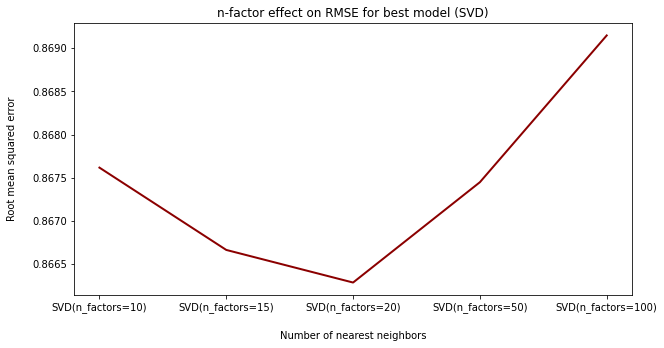

In [ ]:
# Visualizing how the number of neighbors effect the root mean sqaured error
fig7, ax7 = plt.subplots()
svds = model_benchmarks[model_benchmarks['Algorithm'].str.contains('SVD')]
ax7.plot(svds.Algorithm, svds.test_rmse, label="RMSE", color='darkred', linewidth=2)
plt.xlabel("Number of nearest neighbors", labelpad=18)
plt.ylabel("Root mean squared error", labelpad=15)
plt.title("n-factor effect on RMSE for best model (SVD)")
fig7.set_figheight(5)
fig7.set_figwidth(10)
plt.show()

## GridSearchCV on best Model

In [ ]:
from surprise.model_selection import GridSearchCV
from surprise import SVD

param_grid = {'n_epochs': [20,30,50], 'lr_all': [0.005,0.002,0.01], 'reg_all': [0.02,0.1],'n_factors': [20,30,40]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

In [ ]:
gs.fit(train_data)

In [ ]:
# best RMSE score
print(gs.best_score['rmse'])

0.8694603698305213


In [ ]:
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])
print(gs.best_params['mae'])

{'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1, 'n_factors': 40}
{'n_epochs': 50, 'lr_all': 0.002, 'reg_all': 0.02, 'n_factors': 20}


In [ ]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_lr_all,param_reg_all,param_n_factors
0,0.874571,0.874002,0.874331,0.874301,0.000233,7,0.685340,0.685197,0.685246,0.685261,0.000060,6,60.103809,0.234719,19.271295,2.511586,"{'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0...",20,0.005,0.02,20
1,0.874961,0.872863,0.874850,0.874224,0.000964,6,0.685868,0.683943,0.685620,0.685144,0.000855,5,68.587861,0.196583,19.092545,1.230747,"{'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0...",20,0.005,0.02,30
2,0.876430,0.873186,0.874262,0.874626,0.001349,9,0.687053,0.684075,0.685077,0.685402,0.001237,8,76.760780,0.196640,19.729633,2.050187,"{'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0...",20,0.005,0.02,40
3,0.901832,0.899850,0.900568,0.900750,0.000820,40,0.711924,0.709959,0.710793,0.710892,0.000805,42,58.080186,0.415286,18.937253,1.224049,"{'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0...",20,0.005,0.10,20
4,0.901491,0.899559,0.900411,0.900487,0.000790,39,0.711648,0.709733,0.710661,0.710681,0.000782,40,68.875625,0.583239,20.029192,0.091551,"{'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0...",20,0.005,0.10,30


## Train Best Model on Truncated data and test the results (SVD)

In [ ]:
from surprise import SVD

In [ ]:
test_data = test_data.build_full_trainset().build_testset()
train_data = train_data.build_full_trainset()

In [ ]:
algorithmSVDFunk = SVD(n_epochs=50,lr_all=0.01,n_factors=40,reg_all=0.1)
algorithmSVDFunk.fit(train_data)
predictions = algorithmSVDFunk.test(test_data)
accuracy.rmse(predictions)

RMSE: 0.8624


0.8623603960401676

In [ ]:
accuracy.mae(predictions)

MAE:  0.6797


0.6797387138682072

In [ ]:
algorithmSVDFunk2 = SVD(n_epochs=50,lr_all=0.02,reg_all=0.02,n_factors=20)
algorithmSVDFunk2.fit(train_data)
predictions2 = algorithmSVDFunk2.test(test_data)
accuracy.rmse(predictions2)

RMSE: 0.9333


0.9333128066854464

In [ ]:
accuracy.mae(predictions2)

MAE:  0.7212


0.7211530664509227

In [ ]:
print(test.best_params['rmse'])

{'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1, 'n_factors': 40}


#5. Split Full Ratings data into Training, Validation and Test Set

In [ ]:
df_ratings = pd.read_csv("/content/drive/My Drive/Web Mining Project/NEW_DATA/final_netflix_ratings_preprocessed.csv", delimiter=';')
df_ratings.drop(['Unnamed: 0'], axis=1, inplace=True)
df_movies = pd.read_csv("/content/drive/My Drive/Web Mining Project/NEW_DATA/final_movies_metadata_linked.csv", delimiter=';')
df_movies.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
# Train SVD on 75% of known rates
rawTrain, rawTest = train_test_split_sk(df_ratings[['user_id','movie_id','rating']], test_size=0.25, random_state = 42)

In [ ]:
rawTrain.to_csv('/content/drive/My Drive/Web Mining Project/NEW_DATA/train_data_ratings.csv', sep=';', encoding='utf-8')
rawTest.to_csv('/content/drive/My Drive/Web Mining Project/NEW_DATA/test_data_ratings.csv', sep=';', encoding='utf-8')

#6. Baseline Model

In order to provide context for the evaluation of more advanced recommendation models, I will begin with constructing a very simple baseline model. I will use a popularity-based approach, where I calculate the average rating for each movie and simply predict that all users rate all movies after the movies' average rating. Even though this model provides no personalization, most users to in fact rate movies close to the average rating for the movies. I therefore expect that the RMSE for this model will prove to be somewhat challenging to beat.

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
rawTrain = pd.read_csv("/content/drive/My Drive/Web Mining Project/NEW_DATA/train_data_ratings.csv", delimiter=';')
rawTest = pd.read_csv("/content/drive/My Drive/Web Mining Project/NEW_DATA/test_data_ratings.csv", delimiter=';')
rawTrain.drop(['Unnamed: 0'],1,inplace=True)
rawTest.drop(['Unnamed: 0'],1,inplace=True)

print(rawTrain.info())
print(rawTest.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54469341 entries, 0 to 54469340
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   movie_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 1.2 GB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18156448 entries, 0 to 18156447
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   movie_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 415.6 MB
None


In [ ]:
# Creating a new dataframe with the average rating for each movie. 
# The "prediction" for the baseline "model" will actually just be these averages for each movie.

baseline_y_pred = pd.DataFrame(rawTrain.groupby('movie_id')['rating'].mean())

# Merging the training and validation datasets on the movie ID
y_pred_and_y_true = pd.merge(rawTest, baseline_y_pred, on='movie_id', how='left')
y_pred_and_y_true

,user_id,movie_id,rating_x,rating_y
0,1424768,1180,4,3.958263
1,653392,15472,4,3.674685
2,1222598,872,5,4.196201
3,341108,10234,3,3.089367
4,2533261,4912,5,4.012512
...,...,...,...,...
18156443,2220881,3418,4,3.254079
18156444,509704,16660,5,3.762646
18156445,2061818,10239,5,3.649268
18156446,796863,3333,3,3.262850


In [ ]:
# calculating RMSE for the baseline model
print("RMSE baseline model: ", sqrt(mean_squared_error(baseline_y_pred_vs_y_true["rating_y"], 
                                                       baseline_y_pred_vs_y_true["rating_x"])))

RMSE baseline model:  0.9904985347056529


In [ ]:
users_avg = pd.DataFrame(rawTrain.groupby('user_id')['rating'].mean())
users_avg.head()

,rating
user_id,
6,3.430288
7,3.984429
10,3.414773
42,3.875000
59,3.732673


In [ ]:
y_pred_and_y_true = pd.merge(y_pred_and_y_true, users_avg, on='user_id', how='left')
y_pred_and_y_true.head()

,user_id,movie_id,rating_x,rating_y,rating
0,1424768,1180,4,3.958263,3.275781
1,653392,15472,4,3.674685,3.567050
2,1222598,872,5,4.196201,4.039130
3,341108,10234,3,3.089367,3.880857
4,2533261,4912,5,4.012512,3.441472


In [ ]:
 pred_arr = []
 for row in y_pred_and_y_true.itertuples():
   pred_arr.append(((getattr(row, 'rating')+getattr(row, 'rating_y'))/2))

y_pred_and_y_true['baseline_user_movie_avg'] = pred_arr
y_pred_and_y_true.head()

,user_id,movie_id,rating_x,rating_y,rating,baseline_user_movie_avg
0,1424768,1180,4,3.958263,3.275781,3.617022
1,653392,15472,4,3.674685,3.567050,3.620867
2,1222598,872,5,4.196201,4.039130,4.117666
3,341108,10234,3,3.089367,3.880857,3.485112
4,2533261,4912,5,4.012512,3.441472,3.726992


In [ ]:
# calculating RMSE for the baseline model
print("RMSE baseline model: ", sqrt(mean_squared_error(y_pred_and_y_true["baseline_user_movie_avg"], 
                                                       y_pred_and_y_true["rating_x"])))

RMSE baseline model:  0.9441143164255592


In [ ]:
y_pred_and_y_true.head()

,user_id,movie_id,rating_x,rating_y,rating,baseline_user_movie_avg
0,1424768,1180,4,3.958263,3.275781,3.617022
1,653392,15472,4,3.674685,3.567050,3.620867
2,1222598,872,5,4.196201,4.039130,4.117666
3,341108,10234,3,3.089367,3.880857,3.485112
4,2533261,4912,5,4.012512,3.441472,3.726992


In [ ]:
baseline1 = y_pred_and_y_true[['user_id', 'movie_id', 'rating_x', 'rating_y']]
baseline2 = y_pred_and_y_true[['user_id', 'movie_id', 'rating_x', 'baseline_user_movie_avg']]

In [ ]:
baseline2['predicted_rating'] = baseline2['baseline_user_movie_avg']
baseline2['rating'] = baseline2['rating_x'] 
baseline2.head()

,user_id,movie_id,rating_x,baseline_user_movie_avg,predicted_rating,rating
0,1424768,1180,4,3.617022,3.617022,4
1,653392,15472,4,3.620867,3.620867,4
2,1222598,872,5,4.117666,4.117666,5
3,341108,10234,3,3.485112,3.485112,3
4,2533261,4912,5,3.726992,3.726992,5


In [ ]:
baseline1['predicted_rating'] = baseline1['rating_y']
baseline1['rating'] = baseline1['rating_x'] 
baseline1.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,user_id,movie_id,rating_x,rating_y,predicted_rating,rating
0,1424768,1180,4,3.958263,3.958263,4
1,653392,15472,4,3.674685,3.674685,4
2,1222598,872,5,4.196201,4.196201,5
3,341108,10234,3,3.089367,3.089367,3
4,2533261,4912,5,4.012512,4.012512,5


In [ ]:
baseline2.head()

,user_id,movie_id,rating_x,baseline_user_movie_avg,predicted_rating,rating
0,1424768,1180,4,3.617022,3.617022,4
1,653392,15472,4,3.620867,3.620867,4
2,1222598,872,5,4.117666,4.117666,5
3,341108,10234,3,3.485112,3.485112,3
4,2533261,4912,5,3.726992,3.726992,5


In [ ]:
baseline2[['user_id', 'movie_id', 'rating', 'predicted_rating']].to_csv('/content/drive/My Drive/Web Mining Project/NEW_DATA/Results/test_data_predictions_baseline2.csv', sep=';', encoding='utf-8', index=False)

In [ ]:
baseline1[['user_id', 'movie_id', 'rating', 'predicted_rating']].to_csv('/content/drive/My Drive/Web Mining Project/NEW_DATA/Results/test_data_predictions_baseline1.csv', sep=';', encoding='utf-8', index=False)

#7. Train Best Model with Full Training Data (SVD)

In [ ]:
!pip install surprise
from surprise import SVD
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

     |████████████████████████████████| 11.8MB 4.8MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617654 sha256=0ab5a516e8458cbdf670b69802e5ad414d75567da9e14a14236021e4840eacd7
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
# Instantiate a reader with the specified rating scale
# and read in the rating data
reader = Reader(rating_scale=(0, 5))

rawTrain = pd.read_csv("/content/drive/My Drive/Web Mining Project/NEW_DATA/train_data_ratings.csv", delimiter=';')
rawTest = pd.read_csv("/content/drive/My Drive/Web Mining Project/NEW_DATA/test_data_ratings.csv", delimiter=';')
rawTrain.drop(['Unnamed: 0'],1,inplace=True)
rawTest.drop(['Unnamed: 0'],1,inplace=True)

print(rawTrain.info())
print(rawTest.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54469341 entries, 0 to 54469340
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   movie_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 1.2 GB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18156448 entries, 0 to 18156447
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   movie_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 415.6 MB
None


In [ ]:
#into surprise:
rawTrain = Dataset.load_from_df(rawTrain,reader) #used to build validation set as well
rawTest = Dataset.load_from_df(rawTest,reader)

In [ ]:
rawTrain = rawTrain.build_full_trainset()
rawTest = rawTest.build_full_trainset().build_testset()

In [ ]:
bestSVDModel = SVD(n_epochs=50,lr_all=0.01,n_factors=40,reg_all=0.1)
bestSVDModel.fit(rawTrain)

In [ ]:
predictions = bestSVDModel.test(rawTest)

In [ ]:
accuracy.rmse(predictions)

RMSE: 0.8658


0.8658258767955219

In [ ]:
bestSVDModelNotBiased = SVD(n_epochs=50,lr_all=0.01,n_factors=40,reg_all=0.1,biased=False)
bestSVDModelNotBiased.fit(rawTrain)

In [ ]:
test_data_df = pd.read_csv("/content/drive/My Drive/Web Mining Project/NEW_DATA/test_data_ratings.csv", delimiter=';')

In [ ]:
test_data_df.drop(['Unnamed: 0'], axis=1, inplace=True)
test_data_df.head()

,user_id,movie_id,rating
0,1424768,1180,4
1,653392,15472,4
2,1222598,872,5
3,341108,10234,3
4,2533261,4912,5


In [ ]:
bestSVDModel.predict(1222598, 872)

Prediction(uid=1222598, iid=872, r_ui=None, est=4.642844524556067, details={'was_impossible': False})

In [ ]:
# Training the models and predicting for the users and movies in the validation data
CF_predictions = []

# For every movie in the validation data
for index, row in test_data_df.iterrows():
  CF_predictions.append(bestSVDModel.predict(row['user_id'], row['movie_id']).est)

In [ ]:
test_data_df['predicted_rating'] = CF_predictions
test_data_df.head()

,user_id,movie_id,rating,predicted_rating
0,1424768,1180,4,3.876602
1,653392,15472,4,3.773264
2,1222598,872,5,4.642845
3,341108,10234,3,3.362779
4,2533261,4912,5,3.817387


In [ ]:
test_data_df.to_csv('/content/drive/My Drive/Web Mining Project/NEW_DATA/Results/test_data_predictions_svd.csv', sep=';', encoding='utf-8', index=False)

#8. Build Hybrid Recommender and Predict Movies for User

In [ ]:
df_ratings_baseline = pd.read_csv("/content/drive/My Drive/Web Mining Project/NEW_DATA/Results/test_data_predictions_baseline2.csv", delimiter=';')
df_ratings_baseline.head()

,user_id,movie_id,rating,predicted_rating
0,1424768,1180,3.275781,3.617022
1,653392,15472,3.567050,3.620867
2,1222598,872,4.039130,4.117666
3,341108,10234,3.880857,3.485112
4,2533261,4912,3.441472,3.726992


In [ ]:
#read predicted ratings from different models
df_ratings_knn = pd.read_csv("/content/drive/My Drive/Web Mining Project/NEW_DATA/Results/test_data_predictions_knn_item.csv", delimiter=';')
df_ratings_svd = pd.read_csv("/content/drive/My Drive/Web Mining Project/NEW_DATA/Results/test_data_predictions_svd.csv", delimiter=';')
df_ratings_svd.head()

,user_id,movie_id,rating,predicted_rating
0,1424768,1180,4,3.876602
1,653392,15472,4,3.773264
2,1222598,872,5,4.642845
3,341108,10234,3,3.362779
4,2533261,4912,5,3.817387


## Find Best Weights of SVD, KNN by RMSE

In [ ]:
df_ratings_knn.head()

,user_id,movie_id,rating,predicted_rating
0,1424768,1180,4,3.847905
1,653392,15472,4,3.855763
2,1222598,872,5,4.787905
3,341108,10234,3,3.430246
4,2533261,4912,5,3.982145


In [ ]:
from sklearn.metrics import mean_squared_error


# Extracting the validation prediction from the improved content dataframe containing all predictions
KNN_y_pred = df_ratings_knn['predicted_rating'].values
svd_y_pred = df_ratings_svd['predicted_rating'].values
y_val = df_ratings_knn["rating"]

In [ ]:
# Calculating the predictions for the different hybrid "models": 
# different weighted averages of CF and improved CBF filtering
print("RMSE combined approach (KNN-30 and SVD):")
weighted_avgs = [(0.5, 0.5), (0.45, 0.55), (0.4, 0.6), (0.35, 0.65), (0.3, 0.7), (0.25, 0.75), (0.20, 0.80)]

for weight in weighted_avgs:
    combined_predictions = ((np.array(KNN_y_pred) * weight[0]) + (np.array(svd_y_pred)) * weight[1])
    print(f"RMSE for combined approach with CBF weighted {weight[0]} and CF weighted {weight[1]}: \n",
          sqrt(mean_squared_error(y_val, combined_predictions)), "\n")

RMSE combined approach (Lasso and KNN-40):
RMSE for combined approach with CBF weighted 0.5 and CF weighted 0.5: 
 0.8532084132274091 

RMSE for combined approach with CBF weighted 0.45 and CF weighted 0.55: 
 0.8538313185626913 

RMSE for combined approach with CBF weighted 0.4 and CF weighted 0.6: 
 0.8545975352063654 

RMSE for combined approach with CBF weighted 0.35 and CF weighted 0.65: 
 0.8555066780972029 

RMSE for combined approach with CBF weighted 0.3 and CF weighted 0.7: 
 0.85655829213361 

RMSE for combined approach with CBF weighted 0.25 and CF weighted 0.75: 
 0.8577518533017605 

RMSE for combined approach with CBF weighted 0.2 and CF weighted 0.8: 
 0.8590867699645867 



In [ ]:
# Calculating the predictions for the different hybrid "models": 
# different weighted averages of CF and improved CBF filtering
print("RMSE combined approach (SVD and KNN-30 Item based):")
weighted_avgs = [(0.5, 0.5), (0.45, 0.55), (0.4, 0.6), (0.35, 0.65), (0.3, 0.7), (0.25, 0.75), (0.20, 0.80)]

for weight in weighted_avgs:
    combined_predictions = ((np.array(svd_y_pred) * weight[0]) + (np.array(KNN_y_pred)) * weight[1])
    print(f"RMSE for combined approach with CBF weighted {weight[0]} and CF weighted {weight[1]}: \n",
          sqrt(mean_squared_error(y_val, combined_predictions)), "\n")

RMSE combined approach (SVD and KNN-30 Item based):
RMSE for combined approach with CBF weighted 0.5 and CF weighted 0.5: 
 0.8532084132274091 

RMSE for combined approach with CBF weighted 0.45 and CF weighted 0.55: 
 0.8527291332606068 

RMSE for combined approach with CBF weighted 0.4 and CF weighted 0.6: 
 0.8523937209333261 

RMSE for combined approach with CBF weighted 0.35 and CF weighted 0.65: 
 0.8522023461171407 

RMSE for combined approach with CBF weighted 0.3 and CF weighted 0.7: 
 0.8521551058547839 

RMSE for combined approach with CBF weighted 0.25 and CF weighted 0.75: 
 0.8522520241143579 

RMSE for combined approach with CBF weighted 0.2 and CF weighted 0.8: 
 0.8524930517285652 



In [ ]:
# Calculating the hybrid recommendations
hybrid_predictions_test = (np.array([y_pred * 0.3 for y_pred in np.array(svd_y_pred)]) 
                           + np.array([y_pred * 0.7 for y_pred in np.array(KNN_y_pred)]))

# Displaying the test results from training the Hybrid Recommender on test data
print(f"RMSE hybrid recommendations (test data): {sqrt(mean_squared_error(y_val, hybrid_predictions_test))} ")

RMSE hybrid recommendations (test data): 0.8521551058547839 


## Predict Movies for user based on their preferences

In [ ]:
df_train = pd.read_csv("/content/drive/My Drive/Web Mining Project/NEW_DATA/train_data_ratings.csv", delimiter=';')

In [ ]:
#Read Extended Data

df_titles_extended = pd.read_csv("/content/drive/My Drive/Web Mining Project/NEW_DATA/final_movies_metadata_linked.csv", delimiter=';')
df_titles_extended.drop(['Unnamed: 0'], axis=1, inplace=True)
df_titles_extended.head()

,netflix_id,title,release_year,metadata_id,imdb_id,original_language,overview,tagline,metadata_genres,netflix_genres
0,402,Pan Tadeusz,1999,4966,tt0170351,pl,A grand and patriotic tale of Poland's struggl...,NaN,"[{'id': 10752, 'name': 'War'}, {'id': 18, 'nam...",Drama|History|Romance|War
1,17617,Ginger,1971,89072,tt0067133,en,The police suspect that a drug and forced-pros...,"Every man wanted her, no man could tame her! T...","[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",Action|Crime|Drama
2,11805,The Big Bounce,2004,12634,tt0315824,en,A small-time con artist and a Hawaiian real es...,It's all in who you trust,"[{'id': 35, 'name': 'Comedy'}, {'id': 80, 'nam...",Comedy|Crime
3,459,Basquiat,1996,549,tt0115632,en,Director Julian Schnabel illustrates the portr...,"In 1981, A Nineteen-Year-Old Unknown Graffiti ...","[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",Biography|Drama
4,4607,Melody Time,1948,13757,tt0040580,en,Melody Time is an animated feature produced by...,NaN,"[{'id': 10402, 'name': 'Music'}, {'id': 10751,...",Animation|Comedy|Family|Musical


In [ ]:
df_ratings_knn['hybrid_rating'] = hybrid_predictions_test
df_ratings_knn['svd_rating'] = df_ratings_svd['predicted_rating']
df_ratings_knn.head()

,user_id,movie_id,rating,predicted_rating,hybrid_rating,svd_rating
0,1424768,1180,4,3.847905,3.856514,3.876602
1,653392,15472,4,3.855763,3.831013,3.773264
2,1222598,872,5,4.787905,4.744387,4.642845
3,341108,10234,3,3.430246,3.410006,3.362779
4,2533261,4912,5,3.982145,3.932718,3.817387


In [ ]:
df_ratings_knn = pd.merge(df_ratings_knn, df_titles_extended[['netflix_id', 'title', 'netflix_genres']], how='left', left_on='movie_id', right_on='netflix_id')
df_ratings_knn.head()

In [ ]:
df_train = pd.merge(df_train, df_titles_extended[['netflix_id', 'title', 'netflix_genres']], how='left', left_on='movie_id', right_on='netflix_id')
df_train.head()

,Unnamed: 0,user_id,movie_id,rating,netflix_id,title,netflix_genres
0,23722224,2498079,5939,1,5939,The Mummy Returns,Action|Adventure|Fantasy|Thriller
1,32803043,610142,8078,1,8078,Waiting to Exhale,Comedy|Drama|Romance
2,46916642,173067,11812,3,11812,Million Dollar Baby,Drama|Sport
3,38245772,2375482,9617,3,9617,Stepmom,Comedy|Drama
4,72474559,805257,17709,4,17709,A River Runs Through It,Drama


In [ ]:
df_ratings_knn[df_ratings_knn['user_id']==653392][['movie_id', 'hybrid_rating', 'title', 'netflix_genres']].sort_values('hybrid_rating', ascending=False)[:5]

,movie_id,hybrid_rating,title,netflix_genres
8303134,2452,4.324915,The Lord of the Rings: The Fellowship of the Ring,Action|Adventure|Drama|Fantasy
13119963,11283,4.252193,Forrest Gump,Drama|Romance
13035233,9144,4.196103,Gone in 60 Seconds,Action|Crime|Drama|Thriller
11483126,17157,4.190068,Saving Private Ryan,Drama|War
17113428,13673,4.133205,Toy Story,Animation|Adventure|Comedy|Family|Fantasy


In [ ]:
def get_top_rated_movies(df_ratings, user_id):
  if user_id in rawTrain.user_id.unique():
    return df_ratings[df_ratings['user_id']==user_id][['movie_id', 'rating', 'title', 'netflix_genres']].sort_values('rating', ascending=False)[:10]
  else:
    print("User Id does not exist in the list!")
    return None

In [ ]:
def recommend_movies(df, user_id, columnName='hybrid_rating', k=10):
  if user_id in rawTrain.user_id.unique():
    return df[df['user_id']==user_id][['movie_id', 'hybrid_rating', 'title', 'netflix_genres']].sort_values(columnName, ascending=False)[:k]
  else:
    print("User Id does not exist in the list!")
    return None

In [ ]:
get_top_rated_movies(df_train, 653392)

,movie_id,rating,title,netflix_genres
50634033,11040,5,Radio,Biography|Drama|Sport
23471033,17169,5,National Treasure,Action|Adventure|Mystery|Thriller
36607929,6972,5,Armageddon,Action|Adventure|Sci-Fi|Thriller
29734607,9340,5,Pearl Harbor,Action|Drama|History|Romance|War
35911761,15124,5,Independence Day,Action|Adventure|Sci-Fi
46302018,7745,5,Apollo 13,Adventure|Drama|History
13863065,15205,5,The Day After Tomorrow,Action|Adventure|Sci-Fi|Thriller
8358005,2782,5,Braveheart,Biography|Drama|History|War
4448856,7234,5,Men of Honor,Biography|Drama
14279449,13728,5,Gladiator,Action|Adventure|Drama


In [ ]:
recommend_movies(df_ratings_knn, 653392)

,movie_id,hybrid_rating,title,netflix_genres
8303134,2452,4.324915,The Lord of the Rings: The Fellowship of the Ring,Action|Adventure|Drama|Fantasy
13119963,11283,4.252193,Forrest Gump,Drama|Romance
13035233,9144,4.196103,Gone in 60 Seconds,Action|Crime|Drama|Thriller
11483126,17157,4.190068,Saving Private Ryan,Drama|War
17113428,13673,4.133205,Toy Story,Animation|Adventure|Comedy|Family|Fantasy
16846260,1905,4.051729,Pirates of the Caribbean: The Curse of the Bla...,Action|Adventure|Fantasy
14968145,886,4.040256,Ray,Biography|Drama|Music
12935180,14691,4.036914,The Matrix,Action|Sci-Fi
16183539,11781,4.002613,Indiana Jones and the Temple of Doom,Action|Adventure
7456311,16872,3.949946,Tombstone,Action|Biography|Drama|History|Western


#9. Try Precision@K and Recall@K on results

In [ ]:
from collections import defaultdict

def precision_recall_at_k(df_predictions, column_name, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the df_predictions to each user.
    user_est_true = defaultdict(list)
    for row in df_predictions.itertuples():
      
      uid = getattr(row, 'user_id')
      est = getattr(row, column_name)
      true_r = getattr(row, 'rating')
      user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

## Baseline Evaluation

In [ ]:
precisions, recalls = precision_recall_at_k(df_ratings_baseline, 'predicted_rating', k=5)
precisions1, recalls1 = precision_recall_at_k(df_ratings_baseline, 'predicted_rating', k=5, threshold=4)
precisions2, recalls2 = precision_recall_at_k(df_ratings_baseline, 'predicted_rating', k=10)
precisions3, recalls3 = precision_recall_at_k(df_ratings_baseline, 'predicted_rating', k=10, threshold=4)

print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

print(sum(prec for prec in precisions1.values()) / len(precisions1))
print(sum(rec for rec in recalls1.values()) / len(recalls1))

print(sum(prec for prec in precisions2.values()) / len(precisions2))
print(sum(rec for rec in recalls2.values()) / len(recalls2))

print(sum(prec for prec in precisions3.values()) / len(precisions3))
print(sum(rec for rec in recalls3.values()) / len(recalls3))

0.6193606671299513
0.05976295520360853
0.17652536483669215
0.017137529734875114
0.6193606671299513
0.11947991585793276
0.17652536483669215
0.03022868058893311


## Precision Recall (k=5, Threshold=3.5)

                     KNN                SVD                 Hybrid
          Precision  0.8597001775921466 0.8460121998298891 0.8606758551460101
          Recall     0.13564377255350094 0.133686549345696 0.13575156468814348







In [ ]:
#KNN-30
precisions, recalls = precision_recall_at_k(df_ratings_knn, 'predicted_rating', k=5)
precisions1, recalls1 = precision_recall_at_k(df_ratings_knn, 'svd_rating', k=5)
precisions2, recalls2 = precision_recall_at_k(df_ratings_knn, 'hybrid_rating', k=5)

# Precision and recall can then be averaged over all users
print('KNN')
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

print('SVD')
# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions1.values()) / len(precisions1))
print(sum(rec for rec in recalls1.values()) / len(recalls1))

print('Hybrid')
# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions2.values()) / len(precisions2))
print(sum(rec for rec in recalls2.values()) / len(recalls2))

KNN
0.8597001775921466
0.13564377255350094
SVD
0.8460121998298891
0.133686549345696
Hybrid
0.8606758551460101
0.13575156468814348


## Precision Recall (k=5, Threshold=4)


                     KNN                 SVD                 Hybrid
          Precision  0.8046164002778453  0.7565157902864711  0.7943679252566412
          Recall     0.10436755294496013 0.0931423151885729  0.10100809440993119


In [ ]:
#KNN-30
precisions, recalls = precision_recall_at_k(df_ratings_knn, 'predicted_rating', k=5, threshold=4)
precisions1, recalls1 = precision_recall_at_k(df_ratings_knn, 'svd_rating', k=5, threshold=4)
precisions2, recalls2 = precision_recall_at_k(df_ratings_knn, 'hybrid_rating', k=5, threshold=4)

# Precision and recall can then be averaged over all users
print('KNN')
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

print('SVD')
# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions1.values()) / len(precisions1))
print(sum(rec for rec in recalls1.values()) / len(recalls1))

print('Hybrid')
# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions2.values()) / len(precisions2))
print(sum(rec for rec in recalls2.values()) / len(recalls2))

KNN
0.8046164002778453
0.10436755294496013
SVD
0.7565157902864711
0.0931423151885729
Hybrid
0.7943679252566412
0.10100809440993119


## Precision Recall (k=10, Threshold=3.5)


                     KNN                 SVD                 Hybrid
          Precision  0.8315404914486665  0.8180770413014625  0.8327369168028343
          Recall     0.24935733857818435 0.2451773193382814  0.24939249323848486


In [ ]:
#KNN-30
precisions, recalls = precision_recall_at_k(df_ratings_knn, 'predicted_rating', k=10)
precisions1, recalls1 = precision_recall_at_k(df_ratings_knn, 'svd_rating', k=10)
precisions2, recalls2 = precision_recall_at_k(df_ratings_knn, 'hybrid_rating', k=10)

# Precision and recall can then be averaged over all users
print('KNN')
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

print('SVD')
# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions1.values()) / len(precisions1))
print(sum(rec for rec in recalls1.values()) / len(recalls1))

print('Hybrid')
# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions2.values()) / len(precisions2))
print(sum(rec for rec in recalls2.values()) / len(recalls2))

KNN
0.8315404914486665
0.24935733857818435
SVD
0.8180770413014625
0.24517731933828144
Hybrid
0.8327369168028343
0.24939249323848486


## Precision Recall (k=10, Threshold=4)

                     KNN                 SVD                 Hybrid
          Precision  0.7907227130827876  0.7459773670717814  0.7820047137372996
          Recall     0.17483637350516565 0.15294468808262657 0.16798904467074305

In [ ]:
#KNN-30
precisions, recalls = precision_recall_at_k(df_ratings_knn, 'predicted_rating', k=10, threshold=4)
precisions1, recalls1 = precision_recall_at_k(df_ratings_knn, 'svd_rating', k=10, threshold=4)
precisions2, recalls2 = precision_recall_at_k(df_ratings_knn, 'hybrid_rating', k=10, threshold=4)

# Precision and recall can then be averaged over all users
print('KNN')
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

print('SVD')
# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions1.values()) / len(precisions1))
print(sum(rec for rec in recalls1.values()) / len(recalls1))

print('Hybrid')
# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions2.values()) / len(precisions2))
print(sum(rec for rec in recalls2.values()) / len(recalls2))

KNN
0.7907227130827876
0.17483637350516565
SVD
0.7459773670717814
0.15294468808262657
Hybrid
0.7820047137372996
0.16798904467074305
